# Visualising the Poisson-Boltzmann Equation for Potentiometric Sensors: Changes in Surface Potential due to Changes in Surface Charge 
#### Benjamin Lowe, 30th November 2018

In the field of potentiometric sensing, there is interest in predicting the relationship between molecules binding to the surface and the change in the surface potential. With this relationship well understood, it would be possible to rationally designing sensors for enhanced response. One of the simplest and most widely used models for modelling surface potentials is the Poisson-Boltzmann equation. 
- In some Poisson-Bolzmann-based models, the binding of a biomolecule is treated as simply adding to the surface charge, and is thus equivelent to assuming an infinitely thin sheet of charge being additively contributed to the surface. This is what will be considered in this iPython notebok. 
- Finite-size interactions are neglected, meaning that the model becomes invalid at very high ionic strength (due to electrolyte collisions) or very high surface charge (due to build up of unrealistically high concentrations of ions at the surface). These effects are sometimes corrected for my the introduction of a Stern layer, which is not considered within this iPython notebook.
- Effects due to ion-ion correlation, which are particularly important for multivalent ions 

The Poisson-Boltzmann Equation has proved accurate for describing the properties of specific systems such as those monovalent 1:1 valence, low-ionic strength electrolyte systems with low surface charges. Unfortunately the systems often relevant to potentiometric biosensing are very different to this with:

* highly charged oxides surface e.g. such as silica at pH 7.4 
* large bulky biomolecules which cannot be treated as a continuum accurately due to steric interactions
* highly charged biomolecules (e.g. DNA) 
* High ionic strengths (e.g. blood samples or Phosphate Buffered Saline for biosensing have a ionic strength close to 0.15 M) 

Whilst these assumptions are far from realistic when modelling highly charged biomolecular analyte such as DNA molecule binding, their ease-of-computation makes them an appealing starting point for understanding the potential-surface charge relationship.


In [1]:
#The commands in this cell will be used for all simulations in the notebook, therefore please run this cell first.  
%pylab inline
import pandas
import sympy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sympy.init_printing()
#%matplotlib  add to each cell if you wish to view using matplotlib GUI rather than in-line ipython figures
#%reset -f # clear the namespace
mycolormap="Blues"
example_colors=sns.color_palette(mycolormap, n_colors=255)

def plot_heatmap(data, xspan, yspan, label, ionic_stren):
    df = pandas.DataFrame(np.array(data), columns=xspan, index=yspan)
    df = df[df.columns].astype(float)
    fig=plt.figure()
    ax = fig.add_subplot(111)
    a=plt.contourf(xspan,yspan,df,25,extend='both',cmap=mycolormap) #vmax=100
    cbar=plt.colorbar(a) #ticks=v 
    cbar.ax.set_ylabel(label)
    plt.xlabel("Bare Surface Charge (C/m$^2$)")
    plt.ylabel("Bio Surface Charge (C/m$^2$)")
    plt.title("ionic strength={0:.3f} M".format(ionic_stren))
    plt.tight_layout()
    return fig, ax

Populating the interactive namespace from numpy and matplotlib


## Experimental Data: The Surface Charge of Oxides and Charge Densities
### For the simulations in this notebook, experimental data is used to provide a sensible range of parameters for the silanolate surface charge density, biomolecule charge density and the ionic strength. 

A common oxide material for a sensor surface is silica. The surface of silica charges due to protonation/deprotonation reactions with H$^{+}$ and OH$^{-}$ in water ([B. M. Lowe, C.-K. Skylaris and N. G. Green, J. Colloid Interf. Sci., 2015, 451, 231–244.](http://www.sciencedirect.com/science/article/pii/S0021979715003240))



__Based on INTERFACE papers: [Emami, F. S. et al. Chem. Mater. 2014, 26](http://dx.doi.org/10.1021/cm500365c)__

__e.g. Quartz surfaces, silica nanoparticles >200 nm size, silica at pH > 9__
__with Q2 and Q2/Q3 Hydroxyl terminated surface with silanol density of 9.4 to 4.7 per nm2 have a surface charge of:__
* pH 2: ~0 per nm2
* pH 5: ~0.5 per nm2
* pH 7: ~1.0 per nm2
* pH >9: ~1.5 per nm2

__e.g. Most silica glasses, porous silica, silica nanoparticles <200 nm size__
__with Q3 silanol groups with surface silanol density of 4.7 per nm2__
* pH 3: ~0 per nm2 (0%)
* pH 5: ~0.3 per nm2 (6%)
* pH 7: ~0.6 per nm2 (13%)
* pH > 9: ~0.9 per nm2 (20%)

__Silica surfaces and nanoparticles annealed at 200-1000 °C__
* Q3/Q4 and Q4 with silanol density 4.7 to 0 per nm2
* pH 4: ~0 per nm2
* pH 7: 0-0.6 per nm2 depending on Q3 content

[WolframAlpha](http://www.wolframalpha.com/input/?i=0.2+Coulombs+per+meter+squared+to+elementary+charges+per+nanometer+squared) is convenient for Unit Conversions: e.g. 0.2 C/(m^2) is 1.25 elementary charges/(nm^2) 

__The ionic strength dependence of surface charging based on Titration Experiments of silica colloids can be found in P. Somasundaran. 
Reference: '[Encyclopedia of Surface and Colloid Science](http://books.google.co.uk/books?id=P6jMToZhv_EC&pg=PA1863&dq=effect+of+salt+on+silica+surface+charge&hl=en&sa=X&ei=uXfbU-6ALseY1AWPhYHYBg&ved=0CCEQ6AEwAA#v=onepage&q=effect%20of%20salt%20on%20silica%20surface%20charge&f=false)', Chapter Title:'Electric Charge Density of Silica, Alumina, and Related Surfaces' Volume 3, 2006,  pg 1863, Fig 6. __

For example:
* For 0.1 M, pH=7.5, surface charge ~-0.03 C/m^2 to -0.11 C/m^2 depending on reference
* For 0.01 M pH=7.6, surface charge ~0.05 to 0.03 C/m^2 depending on reference

So a sensible range of parameters would be:
* Intrinsic Surface Charge: sigma_0 -0.01 --> -0.25  C/m^2 for silica
* Ionic Strength: ionic_molar --> 0.01 --> 1M
* Biomolecular Charge: sigma_bio --> (4*1e18)*e #C/m^2 (1 proteins per 1 nm^-2, with 4 charges. --> 0.65 C) 

## Methodology 
First the surface potential is obtained as a function of surface charge. The change in surface potential is calculated before and after analyte binding, assuming that the silanolate (i.e. intrinsic surface charge) ($\sigma_{\text{surf}}$) is additive with the charge contribution from DNA $\sigma_{\text{bio}}$ , i.e. assuming biomolecule is an infinitely thin smeared layer on the surface:$\Delta\phi=\phi(\sigma_{\text{surf}}+\sigma_{\text{bio}})-\phi(\sigma_{\text{surf}}$)



## Poisson-Boltzmann Equation/Gouy-Chapmann Model. 
#### The potential as a function of surface charge for this equation is often called the 'Grahame Equation'. The following equation shows the difference in surface potential due to a change in surface charge by $\sigma_{\text{bio}}$ from the initial surface charge.



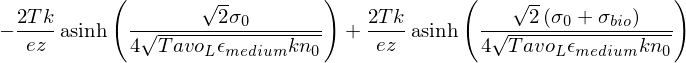

In [2]:
####References that use this equation:#####
#Uslu, F. and Ingebrandt, S. and Mayer, D. and Böcker-Meffert, S. and Odenthal, M. and Offenhäusser, A., "Labelfree Fully Electronic Nucleic Acid Detection System Based on a Field-Effect Transistor Device", Biosens. Bioelectron. 19, 12 (2004), pp. 1723--1731.
#Jayant, Krishna and Auluck, Kshitij and Rodriguez, Sergio and Cao, Yingqiu and Kan, Edwin C., "Programmable Ion-Sensitive Transistor Interfaces. III. Design Considerations, Signal Generation, and Sensitivity Enhanc…", Phys. Rev. E 89, 5 (2014), pp. 052817.
#Sakata, Toshiya and Miyahara, Yuji, "DNA Sequencing Based on Intrinsic Molecular Charges", Angew. Chem. Int. Ed. 45, 14 (2006), pp. 2225--2228.
#Fritz, Jürgen and Cooper, Emily B. and Gaudet, Suzanne and Sorger, Peter K. and Manalis, Scott R., "Electronic Detection of DNA by Its Intrinsic Molecular Charge", PNAS 99, 22 (2002), pp. 14142--14146.
###########################################
psi_0, T, sigma_0, sigma_bio, n_0, z, e, k, epsilon_medium, avo_L = sympy.symbols("psi_0, T, sigma_0, sigma_bio, n_0, z, e, k, epsilon_medium, avo_L")
delta_psi=(2*k*T)/(z*e)*sympy.asinh(((sigma_0+sigma_bio)/sympy.sqrt(8*epsilon_medium*k*T*n_0*avo_L))) - (2*k*T)/(z*e)*sympy.asinh(((sigma_0)/sympy.sqrt(8*epsilon_medium*k*T*n_0*avo_L)))
delta_psi

In [3]:
#Set Global Constants for this iPython notebook
from scipy.constants import epsilon_0, elementary_charge, N_A, Boltzmann
T=298.15 #K
k=Boltzmann #J/K
e=elementary_charge #Coulombs
z=1 #electrolyte valence
avo_L=N_A #mol^-1
epsilon_medium=epsilon_0*80 #free space * relative permitivity of water: F/m or m-3 kg-1 s4 A2 or C/epsilon_0

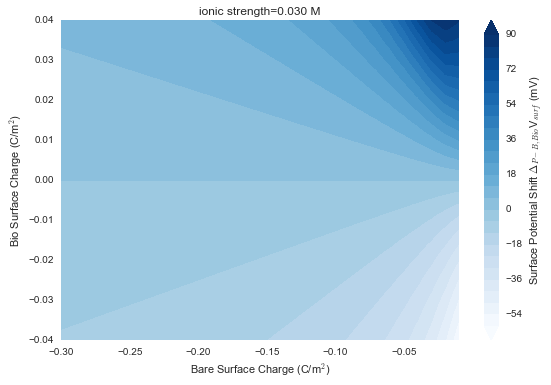

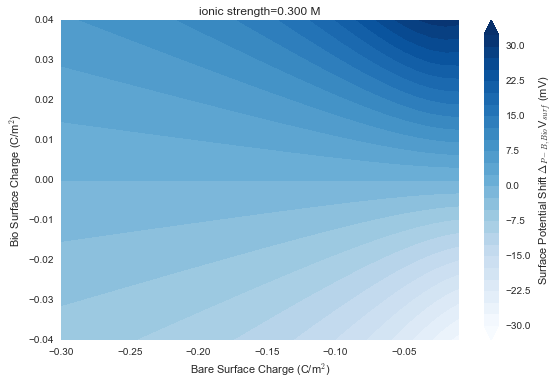

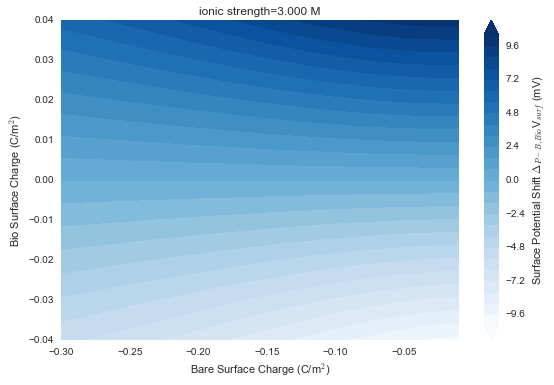

In [4]:
def delta_psi_monovalent(x,y, ionic_stren):
    """This function find the change in surface potential due to addition of additional charge to the surface, e.g. representing biomolecule binding in a BioFET
    The model is the Poisson-Boltzmann Equation (i.e. the Grahame equation solved for potential) for a monovalent 1:1 electrolyte
    Input: The Ionic Strength (in Molar), 'ionic_stren'
    Input: 'x' list of native surface charges (C/m^2)
    Input:  'y' list of biomolecular charges (C/m^2)
    Returns: The change in surface potential (in Volts) due to a biomolecule charge 'y' added to a bare silica surface charge 'x' (C/m^2) 
    
    Note that, unlike the Debye-Hückel equation, this equation has not been linearised by assuming an inverse hyperbolic sine (asinh) term can be apprximated to x^2.
    Linearising results in the simpler, linear, Debye-Huckel equation, and the concept of a Debye Length
    """
    sigma_bio=y
    sigma_0=x
    n_0=ionic_stren*1000 # mol/m^3 
    delta_psi=(2*k*T)/(z*e)*sympy.asinh(((sigma_0+sigma_bio)/sympy.sqrt(8*epsilon_medium*k*T*n_0*avo_L))) - (2*k*T)/(z*e)*sympy.asinh(((sigma_0)/sympy.sqrt(8*epsilon_medium*k*T*n_0*avo_L)))
    return delta_psi*1000 #mV

xchoice="Bare Surface Charge (C/m$^2$)"
ychoice="Ionic Strength (M)"

xspan=np.arange(-0.01,-0.301,-0.01) #Bare Surface Charge (C/m$^2$)
yspan=np.arange(-0.04, 0.041, 0.001) #Bio Surface Charge (C/m$^2$)

#Select ionic strengths in the following list 
for ionic_stren in [0.03,0.3,3]: #0.1627 M = 1x PBS ionic strength

    data=[]
    for y in yspan:
        row=[]
        for x in xspan:
            row.append(delta_psi_monovalent(x,y, ionic_stren))
        data.append(row)

    fig, ax = plot_heatmap(data, xspan, yspan, 'Surface Potential Shift $\Delta$$_{P-B,Bio}$V$_{surf}$ (mV)', ionic_stren)


## Debye-Hückel Equation 
Note: Due to the linearisation this equation is only strictily valid at low surface potentials compared to thermal energy 
e.g. at 300 K with 1:1 electrolyte, valid approximately below [25 mV](https://www.wolframalpha.com/input/?i=boltzmann+constant+*+300+K%2Felementary+charge++in+mV)

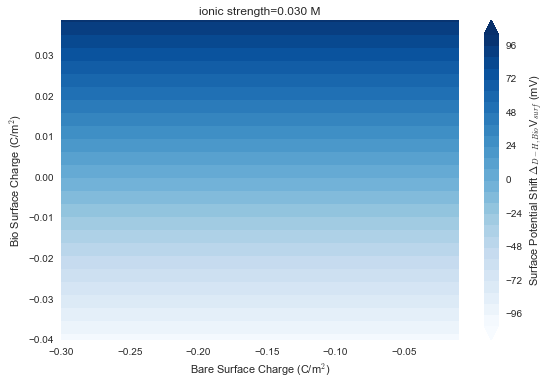

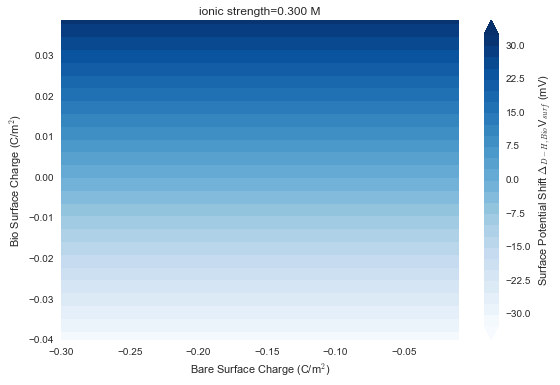

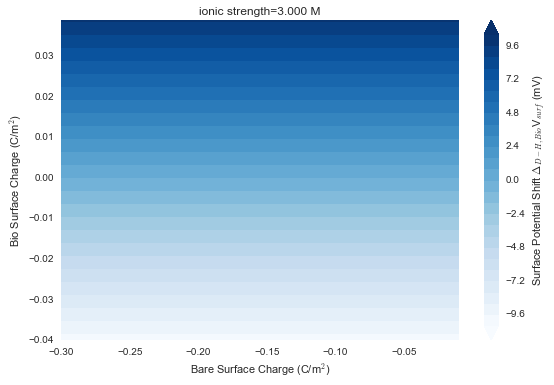

In [5]:
def delta_psi_linear_anyvalent(y, ionic_stren):
    """Calculates the change in surface potential due to addition of additional charge to the surface, e.g. representing biomolecule binding in a BioFET
    The model is the  Debye-Hückel (or linearised Poisson_Boltzmann equation)
    Input: The Ionic Strength (in Molar), 'ionic_stren'
    Input:  'y' list of biomolecular charges to plot (C/m^2)
    Returns: The change in surface potential (in Volts) due to a biomolecule charge 'y' added to a bare silica surface charge 'x' (C/m^2) 
   
    Note that the Debye-Hückel equation is SurfaceCharge/(permitivity*Debye Length) and thus is linear with respect to Surface Charge.
    Thus the difference in surface charge after addition relative to before addition is the same value regardless of the surface charge,
    and thus the equation shows now surface charge dependence on the signal due to biomolecules. 
    """
    number_density_ionic_strength=(ionic_stren*1000.)*avo_L
    kappa=np.sqrt((2*number_density_ionic_strength*(e**2))/(epsilon_medium*k*T))
    sigma_bio=y

    delta_psi=(sigma_bio)/(epsilon_medium*kappa)
    return delta_psi*1000 #mV

xchoice="Bare Surface Charge (C/m$^2$)"
ychoice="Ionic Strength (M)"

#xspan=np.arange(-0.01,-0.3,-0.01) #Bare Surface Charge (C/m$^2$). --> has no effect in this model. 
yspan=np.arange(-0.04, 0.04, 0.001) #Bio Surface Charge (C/m$^2$) 

#Select ionic strengths in the following list 
for ionic_stren in [0.03,0.3,3]: #0.1627 M = 1x PBS ionic strength

    data=[]
    for y in yspan:
        row=[]
        for x in xspan:
            row.append(delta_psi_linear_anyvalent(y, ionic_stren))
        data.append(row)

    fig, ax = plot_heatmap(data, xspan, yspan, 'Surface Potential Shift $\Delta$$_{D-H,Bio}$V$_{surf}$ (mV)', ionic_stren)
    

## Numerical Solution of Poisson-Boltzmann Equation for Mixed Valence Electrolyte
#### e.g. Phosphate Buffered Solution (PBS) 1x PBS buffer: 138 mM NaCl, 2.7 mM KCl, 1.9 mM, NaH$_2$PO$_4$, 8.1 mM Na$_2$HPO$_4$
Note: This is the full (non-linearised) Poisson-Boltzmann Equation. This equation cannot accurately simulate multivalent ions due to correlation between ions results in effects such as 'charge inversionl observed in experiments. [B. M. Lowe, Y. Maekawa, Y. Shibuta, T. Sakata, C.-K. Skylaris and N. G. Green, Phys. Chem. Chem. Phys., 2016, 19, 2687.](http://pubs.rsc.org/en/content/articlelanding/2017/cp/c6cp04101a)


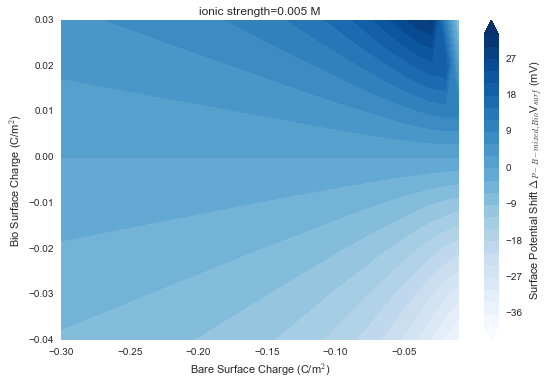

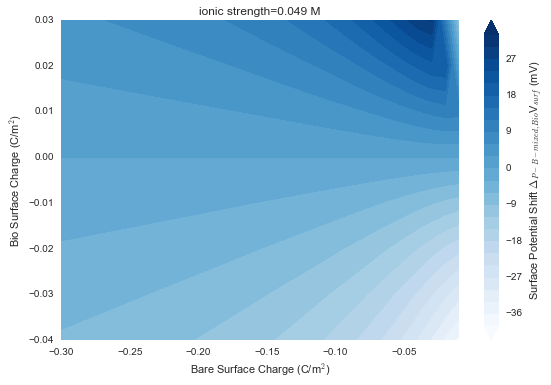

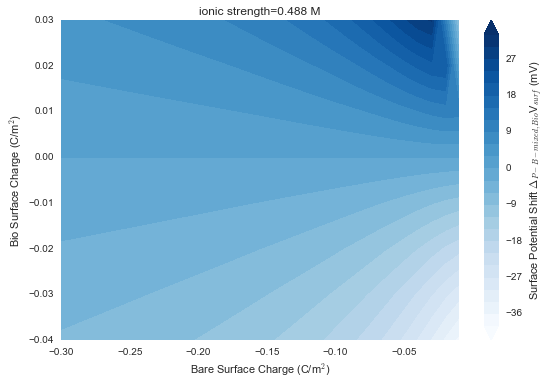

In [6]:
x = sympy.symbols("x") # The potential to be solved for numerically. 

def delta_psi_multivalent(sigma_0,sigma_bio, dilution=1):
    """
    Calculates the change in surface potential due to addition of additional charge to the surface, e.g. representing biomolecule binding in a BioFET
    *Numerically* solves the Poisson-Boltzmann equation for a multivalent system such as Phosphate Buffered Saline 
    The 'system' variable sets the composition of the electrolyte per ion in (ionic strength (M), elementary charge sign and magnitude (q)) tuples, 
    e.g. NaCl at 0.5 M would simply be (0.5, 1), (0.5,-1) for Na+ and Cl-
    Input: 'sigma_0' - The surface charge (C/m^2)
    Input: 'sigma_bio' - The biomolecular charge (C/m^2)
    Input: 'dilution' - A constant multiplying factor to adjust ionic strength (162.7 mM) of the system 
    Returns: Change in surface potential due to biomolecule charge being added to surface charge (mV)
    e.g. The default 'system' is PBS at standard ionic strength (1X) thus if 'dilution' is 0.1, it represents 0.1X PBS at 16.27 mM
    """
    #PBS at 1X ionic strength = 0.1627 M : Reference: N. Lloret, R. S. Frederiksen, T. C. Møller, N. I. Rieben, S. Upadhyay, L. D. Vico, J. H. Jensen, J. Nygård and K. L. Martinez, Nanotechnology, 2013, 24, 035501. (supplementary information)
    system=[(0.138, 1), (0.138,-1), (0.0027, 1), (0.0027, -1), (0.0019, 1), (0.0019, -1), (0.00405, 1), (0.00405, 1), (0.0081, -2)]

    #Solving Grahame Equation, Equation 1.90 from Physics of Soft Colloidal Matter, {Interaction potentials and colloidal stability}, Peter Lang, Fall term 2007/08, pg 35
        #http://arachnoid.com/IPython/equation_solving.html
    sumed=0
    for conc, charge in system:
        number_dens=conc*1000.*avo_L
        sumed+=number_dens*(sympy.exp((-charge*e*x)/(k*T))-1)
    
    prefactor=(2*epsilon_medium*k*T)
    psi_multivalent=sympy.nsolve((prefactor)*sumed - ((sigma_0)**2),x,-1e-3, solver='newton') #1e-3 is x0, initial guess. Solve for sympy symbol x. http://docs.sympy.org/0.7.0/modules/mpmath/calculus/optimization.html
    psi_multivalent_bio=sympy.nsolve((prefactor)*sumed - ((sigma_0+sigma_bio)**2),x,-1e-3, solver='newton')
    delta_psi=psi_multivalent_bio-psi_multivalent
    return delta_psi*1000 #mV

xspan=np.arange(-0.01,-0.31,-0.01) #Bare Surface Charge (C/m$^2$)
yspan=np.arange(-0.04, 0.04, 0.01) #Bio Surface Charge (C/m$^2$) 

#Select ionic strengths in the following list 
for dilution in [0.03,0.3,3]: 

    data=[]
    for current_sigmabio in yspan:
        row=[]
        for current_sigma0 in xspan:
            row.append(delta_psi_multivalent(current_sigma0,current_sigmabio,dilution))
        data.append(row)
    
    fig, ax = plot_heatmap(data, xspan, yspan, 'Surface Potential Shift $\Delta$$_{P-B-mixed,Bio}$V$_{surf}$ (mV)',dilution*0.1627)

## Numerical Solution to the Modified Poisson-Boltzmann Equation
[M. S. Kilic, M. Z. Bazant and A. Ajdari, Phys. Rev. E, 2007, 75, 021502.](http://link.aps.org/doi/10.1103/PhysRevE.75.021502)
Note: The Modified Poisson-Boltzmann predicts the opposite trend to the Poisson-Boltzmann equation: a high surface charged density prior to biomolecule binding is calculated to result in a larger response than a low surface charge density. 

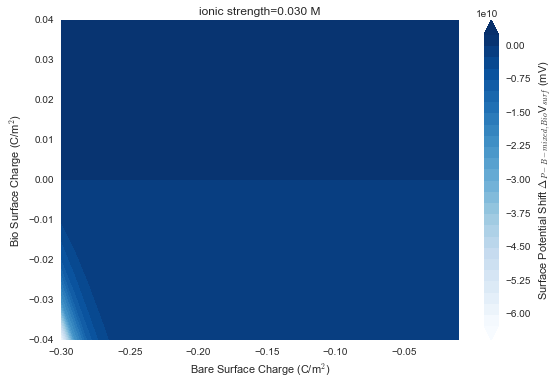

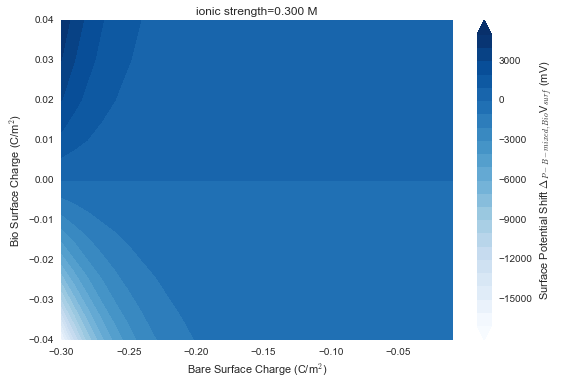

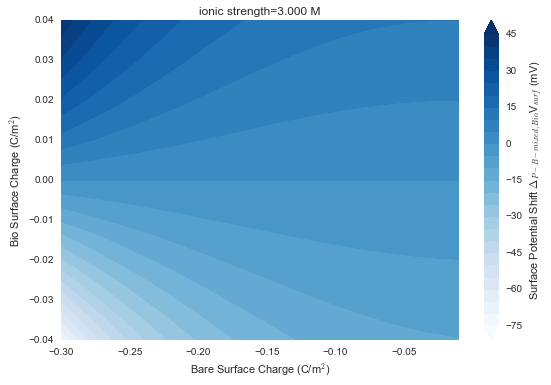

In [7]:
x = sympy.symbols("x") # The potential to be solved for numerically. 

def delta_psi_mpb(sigma_0,sigma_bio, ionic_stren):
    n_0=ionic_stren*1000.0 # mol/m^3 
    number_density_ionic_strength=n_0*avo_L
    kappa=sympy.sqrt((2*n_0*avo_L*(e**2))/(epsilon_medium*k*T))
    debyel=1/kappa
    
    a=184*2e-12 #meters, Size of the ion (in meters, Table 1 paper, Na+) 125 is KCl
    nu=2*(a**3)*number_density_ionic_strength # Packing parameter, unitless
    #Note that q_edl is positive here, but as I want q_surface I've put a negative sign in front which cancels with the negative sign in the paper to make no sign.
    eqn=(sympy.sign(x)*2*e*z*number_density_ionic_strength*debyel*sympy.sqrt((2/nu)*sympy.log(1+2*nu*(sympy.asinh(z*e*x/2/k/T))**2)))-sigma_0
    eqn_bio=(sympy.sign(x)*2*e*z*number_density_ionic_strength*debyel*sympy.sqrt((2/nu)*sympy.log(1+2*nu*(sympy.asinh(z*e*x/2/k/T))**2)))-(sigma_0+sigma_bio)
    psi=sympy.nsolve(eqn, x, -1e-3, solver='newton') #http://docs.sympy.org/0.7.0/modules/mpmath/calculus/optimization.html
    psi_bio=sympy.nsolve(eqn_bio, x, -1e-3, solver='newton')
    delta_psi=psi_bio-psi
    return delta_psi*1000 #mV

xspan=np.arange(-0.01,-0.31,-0.01) #Bare Surface Charge (C/m$^2$)
yspan=np.arange(-0.04, 0.041, 0.01) #Bio Surface Charge (C/m$^2$) 

#Select ionic strengths in the following list 
for ionic_stren in [0.03,0.3,3]: 

    data=[]
    for current_sigmabio in yspan:
        row=[]
        for current_sigma0 in xspan:
            
            row.append(delta_psi_mpb(current_sigma0,current_sigmabio,ionic_stren))
        data.append(row)
    
    fig, ax = plot_heatmap(data, xspan, yspan, 'Surface Potential Shift $\Delta$$_{P-B-mixed,Bio}$V$_{surf}$ (mV)',ionic_stren)